In [2]:
import warnings
warnings.simplefilter("ignore", UserWarning)

## Этап 1. Генерация изображений.

Последовательность выполнения генерации следующая:
1. Создание триплета текстовых изображений (image, character_heatmap, affinity_heatmap) с случайными цветовыми аугментациями к тексту и геометрическими аугментациями к тексту и маскам;
2. Компоновка триплетов на подложке с применением геометрических аугментаций к полученной компоновке (отдельно текст, character_heatmap и affinity_heatmap);
3. Замена подложки фоновым изображением с применением геометрических аугментаций к изображению и маскам, а затем и цветовым аугментациями только к изображению.

При генерации триплетов image, character_heatmap и affinity_heatmap используются случайные `background`, `color`, `font`, `text`, размещённые в `static`, и значения `opacity` и `size`.


Код генерации триплетов приведён в `utils.py`, а генерация общего изображения в `generate_image.py`.

In [36]:
import matplotlib.pyplot as plt

from generate_utils import generate_random_image, save_image_and_mask
from static.constants import backgrounds, colors, fonts, texts, opacities, sizes

In [38]:
%%time
image, heatmap = generate_random_image(
    fonts=fonts, 
    texts=texts, 
    colors=colors, 
    backgrounds=backgrounds, 
    opacities=opacities, 
    sizes=sizes)

CPU times: total: 375 ms
Wall time: 302 ms


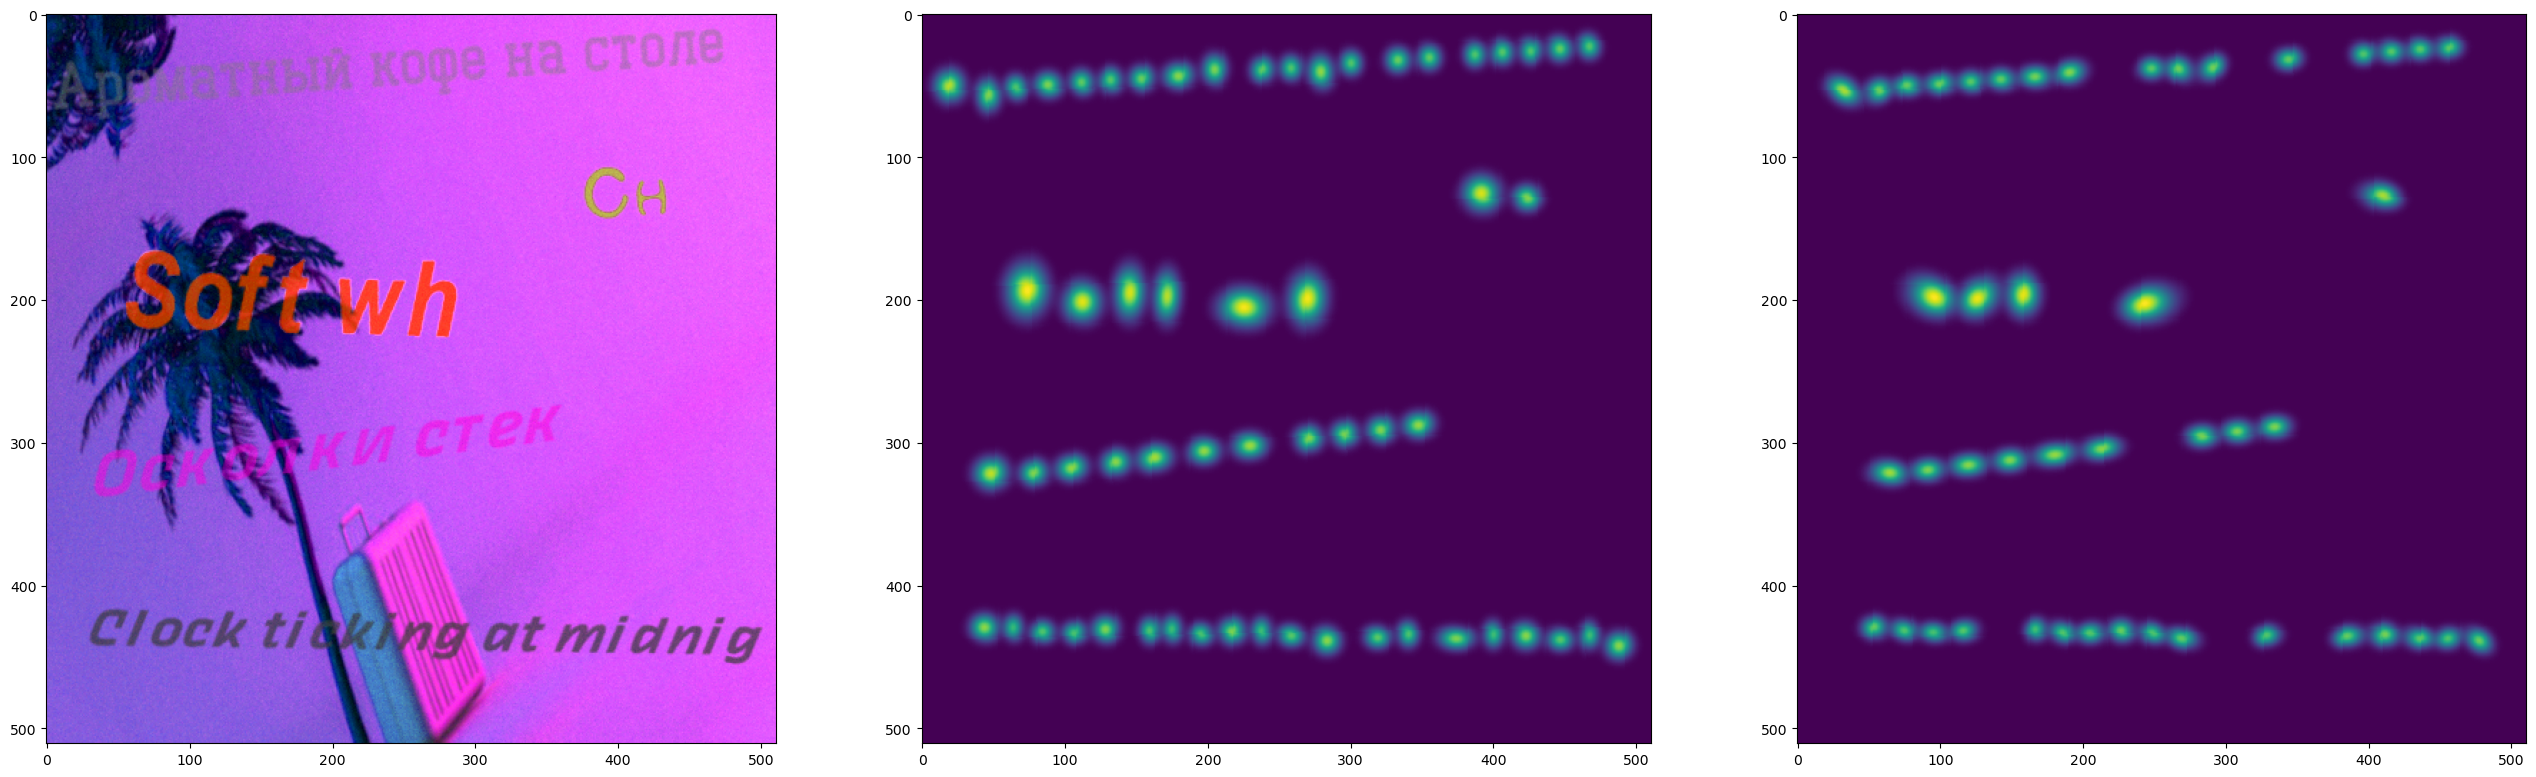

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(32, 32))

ax[0].imshow(image)
ax[1].imshow(heatmap[..., 0])
ax[2].imshow(heatmap[..., 1])

plt.show()

Для сохранения изображения и масок используется функция `save_image_and_mask`.

In [ ]:
save_image_and_mask(
    idx=999,
    image=image,
    heatmap=heatmap,
    images_folder='testing',
    char_masks_folder='testing',
    aff_mask_folder='testing',
)

Для генерирования датасета используется `parallel_generate_images.py`, который ускоряет генерирование и сохранение изображений за счёт многопоточности.

In [45]:
!python generate_images.py --help

usage: generate_images.py [-h] [--num_images NUM_IMAGES]
                          [--chunk_size CHUNK_SIZE]
                          [--num_workers NUM_WORKERS]
                          [--save_folder SAVE_FOLDER]
                          [--show_steps SHOW_STEPS]

Скрипт для создания и сохранения случайных изображений с использованием
многопоточности. Выполнение функций скрипта происходит в двух созависимых
pool-ах: генерации и сохранения. Т.е. генерация следующего chunk_size
количества изображений начнётся только после их сохранения на диск. Это
позволяет не заполнять оперативную память изображениями, которые ещё не успели
сохраниться на диск.

options:
  -h, --help            show this help message and exit
  --num_images NUM_IMAGES
                        Количество генерируемых изображений. По умолчанию:
                        5000
  --chunk_size CHUNK_SIZE
                        Размер порции генерируемых изображений. По умолчанию:
                        100
  --num_worker

In [ ]:
!python generate_images.py --num_images 5000 --save_folder C:\datasets\syntdata

## Этап 2. Дообучение SegFormer на синтетических данных

Последовательность дообучения следующая:
1. Создание модели с на основе предобученной модели сегментации `segformer-b0`;
2. Формирование train/test датасетов синтетичесих данных с кешированием объектов в оперативную память для ускорения циклов обучения;
3. Подбор гиперпараметров обучения модели и запуск процесса обучения с рассчётом метрик.

### 2.1 Создание модели

В качестве предобученного `SegFormer` будет использоваться `nvidia/segformer-b0-finetuned-ade-512-512`.  
В качестве loss-функции будет использоваться комбинированный `DiceFocalLoss`.

In [49]:
from loss_functions import DiceFocalLoss

from train_utils import SegformerForСraft
from transformers import SegformerImageProcessor

In [50]:
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"

feature_extractor = SegformerImageProcessor.from_pretrained(model_name)
model = SegformerForСraft.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True)

Some weights of SegformerForСraft were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Создание датасета

Формирование датасета выполняется из `pd.DataFrame` ссылок на image, character_mask и affinity_mask. Для ускорения итерирования по датасетам, а следовательно и ускорения обучения, выполняется кеширование данных в оперативную память.

In [55]:
from sklearn.model_selection import train_test_split
from train_utils import CRAFTDataset, craft_data_collator, collect_data

In [57]:
dataset = collect_data(r'C:\datasets\syntdata')

train, test = train_test_split(dataset, test_size=0.2, random_state=37)
train, test = train.reset_index(drop=True), test.reset_index(drop=True)

train_dataset = CRAFTDataset(feature_extractor, train, caching=True)
test_dataset = CRAFTDataset(feature_extractor, test, caching=True)

### Обучение

После каждой эпохи обучения проводится валидация с рассчётом метрик на тестовой части датасета с помощью функции `compute_metric`. 
  
Для каждого примера из тестовой части датасета вычисляются координаты bbox-ов текстов на изображении по выходам модели и ground_truth. Для ускорения этого процесса применено параллельное вычисление функции `craft_utils.getDetBoxes()`.  

На основании этих bbox-ов выполняется рассчёт метрик `IoU`, `F1-Score`, `Presicion` и `Recall`.

In [60]:
from transformers import TrainingArguments, Trainer
from train_utils import compute_metrics, inference_sample

In [62]:
training_args = TrainingArguments(
    output_dir="./checkpoints",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_strategy="epoch",  
    save_strategy="epoch",        
    logging_steps=50,
    learning_rate=5e-5,
    weight_decay=0.01,
    eval_accumulation_steps=50

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=craft_data_collator,
    compute_metrics=compute_metrics
)

In [64]:
trainer.train()

Epoch,Training Loss,Validation Loss,Mean Iou,F1,Precision,Recall
1,0.646700,0.622647,0.818776,0.769978,0.748309,0.792940
2,0.549100,0.551271,0.836167,0.842832,0.843631,0.842034
3,0.547200,0.530708,0.846142,0.872732,0.876963,0.868542
4,0.536900,0.523212,0.849259,0.886704,0.895572,0.878009
5,0.514700,0.517385,0.852409,0.895037,0.908825,0.881661
6,0.512800,0.516004,0.854822,0.898491,0.907099,0.890046
7,0.507700,0.512041,0.855849,0.905673,0.912196,0.899243
8,0.513600,0.510435,0.856726,0.905156,0.916771,0.893833
9,0.505200,0.509397,0.857612,0.908892,0.920166,0.897890
10,0.511800,0.508988,0.857864,0.907400,0.917820,0.897214


TrainOutput(global_step=10000, training_loss=0.5534714757919311, metrics={'train_runtime': 902.1733, 'train_samples_per_second': 44.337, 'train_steps_per_second': 11.084, 'total_flos': 7.0111822086144e+17, 'train_loss': 0.5534714757919311, 'epoch': 10.0})

Finetuning модели можно выполнить запустив скрипт `train.py`

In [33]:
!python train.py --help

usage: train.py [-h] [--input_dir INPUT_DIR] [--output_dir OUTPUT_DIR]
                [--model_name MODEL_NAME]
                [--num_train_epochs NUM_TRAIN_EPOCHS]
                [--batch_size BATCH_SIZE] [--learning_rate LEARNING_RATE]
                [--weight_decay WEIGHT_DECAY] [--test_size TEST_SIZE]
                [--caching CACHING]

Скрипт для finetuning предобученной сегментационной модели на синтетических
данных

options:
  -h, --help            show this help message and exit
  --input_dir INPUT_DIR
                        Директория с синтетическими изображениями
  --output_dir OUTPUT_DIR
                        Директория сохранения результатов обучения
  --model_name MODEL_NAME
                        Имя предобученной модели
  --num_train_epochs NUM_TRAIN_EPOCHS
                        Количество эпох обучения
  --batch_size BATCH_SIZE
                        Размер батча
  --learning_rate LEARNING_RATE
  --weight_decay WEIGHT_DECAY
  --test_size TEST_SIZE
         

In [53]:
!python train.py --input_dir dataset --output_dir checkpoits_test --num_train_epochs 10 --caching True

^C


Пример инференса на тестовой части датасета

In [68]:
from PIL import Image

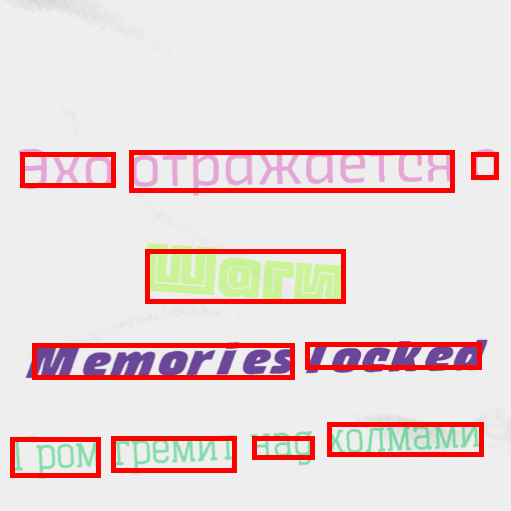

In [88]:
image = Image.open(r'c:datasets/syntdata/images/image_1010.png').convert('RGB')
image, boxes_pred = inference_sample(model, feature_extractor, image, 0.2, 0.2, 0.5)

image

## Этап 3. Настройка гиперпараметров для CRAFT

На этом этапе выполнена настройка гиперпараметров CRAFT, для получаения максимальных значений метрик IoU и F1-Score на тестовой части датасета. В Качестве оптимизатора используется `optuna`, а в качестве оптимизируемых параметров аргументы функции **`craft_utils.getDetBoxes`**, а именно `text_threshold`, `link_threshold` и `low_text`.

In [96]:
import optuna
import torch

Сбор предсказаний модели на тестовом датасете.

In [99]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

prediction_heatmaps, ground_truth_heatmaps = [], []
batch_size = 4

model.eval()
model.to(device)
for idx in range(len(test_dataset) // batch_size):
    batch = test_dataset[idx * batch_size : idx * batch_size + batch_size]

    batch['labels'] = batch['labels'].to(device)
    batch['pixel_values'] = batch['pixel_values'].to(device)
    
    with torch.no_grad():
        outputs = model(**batch)

        prediction = outputs['logits']
        ground_truth = batch['labels']

        prediction_heatmaps.append(prediction)
        ground_truth_heatmaps.append(ground_truth)

prediction_heatmaps_ = torch.concat(prediction_heatmaps).cpu().detach().numpy()
ground_truth_heatmaps = torch.concat(ground_truth_heatmaps).cpu().detach().numpy()

Опеределим целевую функцию, которую будем максимизировать

In [103]:
def objective(trial):
    tt = trial.suggest_float("tt", 0.0, 1.0)
    lt = trial.suggest_float("lt", 0.0, 1.0)
    lwt = trial.suggest_float("lwt", 0.0, 1.0)
    
    metrics = compute_metrics((prediction_heatmaps_, ground_truth_heatmaps), tt=tt, lt=lt, lwt=lwt)
    score = (metrics["mean_iou"] + metrics["f1"]) / 2.0
    return score  

In [105]:
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=50, n_jobs=1, show_progress_bar=True)  # запустим 10 проб

print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.number)
print("Best params:", study.best_params)

[I 2025-03-11 23:14:28,729] A new study created in memory with name: no-name-5d08dc59-37f8-48ae-82aa-f99b6120f43a


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-03-11 23:14:41,217] Trial 0 finished with value: 0.8849163335362442 and parameters: {'tt': 0.5567706844741687, 'lt': 0.31913940076421565, 'lwt': 0.10486253295355119}. Best is trial 0 with value: 0.8849163335362442.
[I 2025-03-11 23:14:53,381] Trial 1 finished with value: 0.8721931337450219 and parameters: {'tt': 0.9634803312384298, 'lt': 0.6352486455941851, 'lwt': 0.36160831318750686}. Best is trial 0 with value: 0.8849163335362442.
[I 2025-03-11 23:15:05,743] Trial 2 finished with value: 0.8717983178691708 and parameters: {'tt': 0.7103162368875221, 'lt': 0.7709960991665831, 'lwt': 0.19424261484508698}. Best is trial 0 with value: 0.8849163335362442.
[I 2025-03-11 23:15:18,069] Trial 3 finished with value: 0.8746158861857098 and parameters: {'tt': 0.07719213056550589, 'lt': 0.3526183499741361, 'lwt': 0.3358078353935444}. Best is trial 0 with value: 0.8849163335362442.
[I 2025-03-11 23:15:30,781] Trial 4 finished with value: 0.6223037501421818 and parameters: {'tt': 0.9489162400

## Этап 4. Валидация на реальных объектах.

На этом этапе выполним валидацию модели на реальных объектах. Для этого будем использовать изображения и аннтоцации к ним из директории `validation_data`

In [116]:
import os
from train_utils import calculate_metric

data_path = os.path.abspath('validation_data/images')

with open('./validation_data/annotations.json', 'r') as file:
    images = [Image.open(os.path.join(data_path, image)) for image in sorted(os.listdir(data_path))]
    gt_bboxes_list = json.load(file)          

In [118]:
pred_bboxes_list = [inference_sample(model, feature_extractor, image, **study.best_params)[1] for image in images]
gt_bboxes_list = [gt_bboxes_list[key] for key in sorted(gt_bboxes_list)]

In [119]:
calculate_metric(pred_bboxes_list, gt_bboxes_list)

{'mean_iou': 0.7730310104346498,
 'f1': 0.5333333328329157,
 'precision': 0.5110565110552554,
 'recall': 0.5576407506687463}

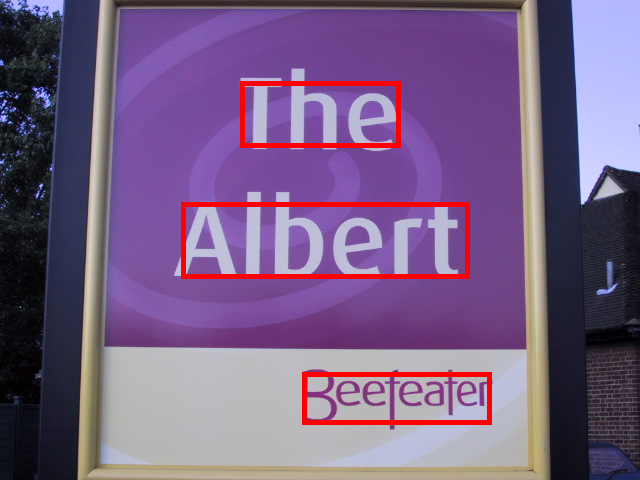

In [130]:
image, _, = inference_sample(model, feature_extractor, images[37], **study.best_params)
image